Лабораторная работа №7. Рекуррентные нейронные сети для анализа текста

In [2]:
# TensorFlow и tf.keras
import tensorflow as tf
from tensorflow import keras
from keras import regularizers

import numpy as np
import matplotlib.pyplot as plt
import pdb
import os
import scipy.io
from sklearn.model_selection import train_test_split
import tarfile
from six.moves import cPickle as pickle
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import re
from collections import defaultdict

Using TensorFlow backend.


Задание 1.
Загрузите данные. Преобразуйте текстовые файлы во внутренние структуры данных, которые используют индексы вместо слов.


In [ ]:
# загрузка и форматирование данных

# used only once
# !bash ../data/movie_reviews/preprocess_reviews.sh

Скрипт из открытого доступа (https://gist.github.com/aaronkub/09985a47740bda278712e1dd78e482cf) объединяет все негативные рецензии и все позитивные в одни файлы. Он исправлен, чтобы файл был не один.

In [3]:
dataset_path = '../data/movie_reviews/aclImdb/data'

def extract_data(filename):
    dataset = []
    with open(os.path.join(dataset_path, filename)) as f:
        for lines in f.readlines():
            dataset.append(lines.strip())
    return dataset


train_pos_reviews = extract_data('full_pos_train.txt')
train_neg_reviews = extract_data('full_neg_train.txt')
test_pos_reviews = extract_data('full_pos_test.txt')
test_neg_reviews = extract_data('full_neg_test.txt')

train_labels = np.concatenate((np.ones(len(train_pos_reviews)), np.zeros(len(train_neg_reviews))), axis=None)
test_labels = np.concatenate((np.ones(len(test_pos_reviews)), np.zeros(len(test_neg_reviews))), axis=None)

In [17]:
print('Train positive lines: ', len(train_pos_reviews))
print('Train negative lines: ', len(train_neg_reviews))
print('Train labels: ', len(train_labels))
print('Test positive lines: ', len(test_pos_reviews))
print('Test negative lines: ', len(test_neg_reviews))
print('Test labels: ', len(test_labels))

Train positive lines:  12500
Train negative lines:  12500
Train labels:  25000
Test positive lines:  12500
Test negative lines:  12500
Test labels:  25000


https://towardsdatascience.com/sentiment-analysis-with-python-part-1-5ce197074184

Препроцессим данные и делаем их чище (убираем заглавные, знаки препинания и так далее).

In [4]:
REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]]")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

def preprocess_reviews(reviews):
    reviews = [REPLACE_NO_SPACE.sub("", line.lower()) for line in reviews]
    reviews = [REPLACE_WITH_SPACE.sub(" ", line) for line in reviews]
    
    return reviews

train_pos_reviews = preprocess_reviews(train_pos_reviews)
train_neg_reviews = preprocess_reviews(train_neg_reviews)
test_pos_reviews = preprocess_reviews(test_pos_reviews)
test_neg_reviews = preprocess_reviews(test_neg_reviews)

In [5]:
# https://stackoverflow.com/questions/51956000/what-does-keras-tokenizer-method-exactly-do
# https://stackoverflow.com/questions/42943291/what-does-keras-io-preprocessing-sequence-pad-sequences-do

tokenizer = keras.preprocessing.text.Tokenizer(num_words=10000, split=' ')
tokenizer.fit_on_texts(train_pos_reviews + train_neg_reviews)

X = tokenizer.texts_to_sequences(train_pos_reviews + train_neg_reviews + test_pos_reviews + test_neg_reviews)
X = tf.keras.preprocessing.sequence.pad_sequences(X)

X_train, X_test = np.split(X, [25000])

y_train = train_labels
y_test = test_labels

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.25)

In [40]:
print('Train X: ', X_train.shape)
print('Valid X: ', X_valid.shape)
print('Test X: ', X_test.shape)
print('Train y: ', y_train.shape)
print('Valid y: ', y_valid.shape)
print('Test y: ', y_test.shape)

Train X:  (18750, 2176)
Valid X:  (6250, 2176)
Test X:  (25000, 2176)
Train y:  (18750,)
Valid y:  (6250,)
Test y:  (25000,)


Задание 2.
Реализуйте и обучите двунаправленную рекуррентную сеть (LSTM или GRU). Какого качества классификации удалось достичь?


In [41]:
embedding_vector_length = 32

lstm_model = keras.models.Sequential([
    keras.layers.Embedding(10000, embedding_vector_length, input_length=X_train.shape[1]),
    keras.layers.LSTM(100),
    keras.layers.Dense(1, activation='sigmoid')
])

lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2176, 32)          320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 373,301
Trainable params: 373,301
Non-trainable params: 0
_________________________________________________________________


In [45]:
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model_history = lstm_model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=3)

Train on 18750 samples, validate on 6250 samples
Epoch 1/3
18750/18750 [==============================] - 945s 50ms/sample - loss: 0.4725 - accuracy: 0.7867 - val_loss: 0.3591 - val_accuracy: 0.8494
Epoch 2/3
18750/18750 [==============================] - 947s 50ms/sample - loss: 0.2834 - accuracy: 0.8877 - val_loss: 0.3431 - val_accuracy: 0.8530
Epoch 3/3
18750/18750 [==============================] - 909s 48ms/sample - loss: 0.2064 - accuracy: 0.9218 - val_loss: 0.4535 - val_accuracy: 0.7906


In [46]:
test_loss, test_acc = lstm_model.evaluate(X_test, y_test, verbose=2)

print('\nТочность на проверочных данных:', test_acc)

25000/25000 - 310s - loss: 0.4565 - accuracy: 0.7914

Точность на проверочных данных: 0.7914


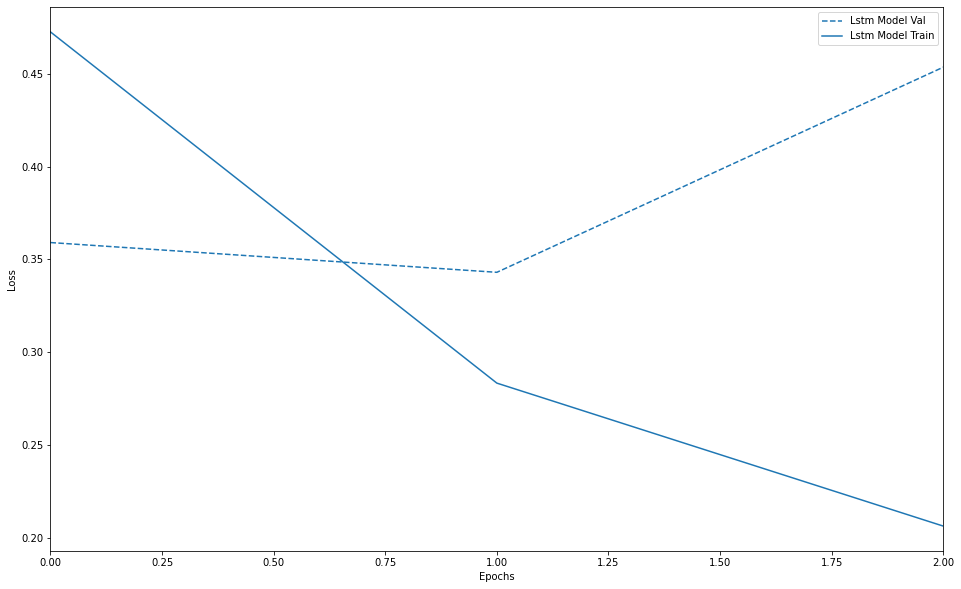

In [47]:
def plot_history(histories, key='binary_crossentropy'):
    plt.figure(figsize=(16,10))

    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_' + key],
                        '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()
    plt.xlim([0,max(history.epoch)])
    plt.show()

plot_history([('lstm model', lstm_model_history)], key='loss')

Задание 3.
Используйте индексы слов и их различное внутреннее представление (word2vec, glove). Как влияет данное преобразование на качество классификации?


In [6]:
def load_embeddings(filename):
    embeddings_index = {}

    with open(filename, 'r') as in_file:
        for line in in_file:
            values = line.split()

            try:
                word = values[0]
                embeddings_index[word] = np.asarray(values[1:], dtype=np.float32)
            except:
                pass

    return embeddings_index


def get_embedding_matrix(embedding, vocab):
    vocab_size = len(vocab) + 1
    weight_matrix = np.zeros((vocab_size, 300))
    
    for word, i in vocab.items():
        weight_matrix[i] = embedding.get(word)

    return weight_matrix


embedding = load_embeddings("../data/movie_reviews/glove/glove.840B.300d.txt")
weight_matrix = get_embedding_matrix(embedding, tokenizer.word_index)

In [9]:
vocab_size = len(tokenizer.word_index) + 1

glove_model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, 300, weights=[weight_matrix], trainable=False),
    keras.layers.LSTM(100),
    keras.layers.Dense(1, activation='sigmoid')
])

glove_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         28131600  
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 28,292,101
Trainable params: 160,501
Non-trainable params: 28,131,600
_________________________________________________________________


In [ ]:
glove_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
glove_model_history = glove_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=4, batch_size=64)

In [ ]:
test_loss, test_acc = glove_model.evaluate(X_test, y_test, verbose=2)

print('\nТочность на проверочных данных:', test_acc)

In [ ]:
plot_history([('glove model', glove_model_history)], key='loss')

Задание 4.

Поэкспериментируйте со структурой сети (добавьте больше рекуррентных, полносвязных или сверточных слоев). Как это повлияло на качество классификации?

In [ ]:
embedding_vecor_length = 32

diff_model = keras.models.Sequential([
    keras.layers.Embedding(10000, embedding_vector_length, input_length=X_train.shape[1]),
    keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2),
    keras.layers.Dense(1, activation='sigmoid')
])

diff_model.summary()

In [ ]:
diff_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
diff_model_history = diff_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=64)

In [ ]:
test_loss, test_acc = diff_model.evaluate(X_test, y_test, verbose=2)

print('\nТочность на проверочных данных:', test_acc)

In [ ]:
plot_history([('diff model', diff_model_history)], key='loss')